## Problem 5: Convolutional Neural Networks (PyTorch Implementation)

Time to implement your first convolutional neural network (CNN) in PyTorch!

For this assignment, we'll be training the network on the canonical MNIST dataset. After building the network, we'll experiment with an array of hyperparameters, tweaking the network's width, depth, learning rate and more in pursuit of the highest classification accuracy we can muster.

You may find the PyTorch tutorials helpful as you complete this problem: https://pytorch.org/tutorials/beginner/basics/intro.html. If you haven't yet, we suggest you go through them. Pay more attention to the tutorial on the optimization loop, which you will need to build more or less from scratch.

### Step 0: Setup Environment

If you haven't set up PyTorch locally, you can do so following this [local installation guide](https://pytorch.org/get-started/locally/).


Installing PyTorch locally is **not** necessary for the course. You can access PyTorch either through:

- the class partition `cpsc452` on [McCleary](https://docs.ycrc.yale.edu/clusters/mccleary/)

- use of [Google Colab](https://colab.research.google.com)

If you are new to the Yale High Performance Clusters (HPC) please consulte this [guide](https://docs.ycrc.yale.edu/clusters-at-yale/)
<div style="display:none">

```bash
[mccleary ~]$ salloc ---reservation=cpsc452
[cpsc452_netID@gpu ~]$  bash
```

```bash
# sbatch.script
@SBATCH -p cpsc452
```

As usual, we'll start by importing the necessary libraries and setting up our environment. Please run the following cell to do so.

In [1]:
!pip install numpy matplotlib tqdm

In [2]:
from typing import Callable

import torch
import torch.nn as nn            # neural network modules
import torch.nn.functional as F  # activation functions
import torch.optim as optim      # optimizer
import torch.utils.data          # dataloader
import torchvision.datasets as datasets

import numpy as np
import matplotlib.pyplot as plt
import tqdm

torch.manual_seed(42)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.26MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.07MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



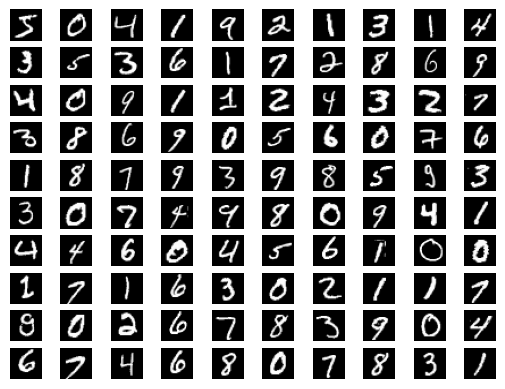

In [3]:
# Download the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=None)

# Load into torch datasets
train_dataset = torch.utils.data.TensorDataset(mnist_train.data.unsqueeze(1).float(), mnist_train.targets.long())
test_dataset = torch.utils.data.TensorDataset(mnist_test.data.unsqueeze(1).float(), mnist_test.targets.long())

# Visualize the data
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(train_dataset[i][0][0], cmap='gray')
    plt.axis('off')

### Step 1: Learn PyTorch Basics

In this section, you will learn different PyTorch basic operations (`Conv2d`, `MaxPool`, `Linear`) and reshape operations. You might refer to PyTorch documentation for details of these operations.

In [4]:
# Part 1: Explore `nn.Module`
image = torch.randn(1, 1, 28, 28)  # image: (1, 1, 28, 28)


# TODO: define a 3x3 convolutional layer that maps 1 input channel to 32 output channels
# refer to https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
# you might need to specify the input channels, output channels, kernel size, stride, padding, etc.
conv_1 = torch.nn.Conv2d(1, 32, 3, padding=1)
output_1 = conv_1(image)    # image: (1, 1, 28, 28) -> output_1: (1, 32, 28, 28)
assert output_1.shape == (1, 32, 28, 28), "The shape of output_1 is incorrect!"


# TODO: define a max pooling layer that halves the height and width of the input
# refer to https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
# you might need to specify the kernel size, stride, padding, etc.
pool_1 = torch.nn.MaxPool2d(2)
output_2 = pool_1(output_1) # output_1: (1, 32, 28, 28) -> output_2: (1, 32, 14, 14)
assert output_2.shape == (1, 32, 14, 14), "The shape of output_2 is incorrect!"


# TODO: define a 3x3 convolutional layer that maps 32 input channels to 64 output channels
conv_2 = torch.nn.Conv2d(32, 64, 3, padding=1)
output_3 = conv_2(output_2) # output_2: (1, 32, 14, 14) -> output_3: (1, 64, 14, 14)
assert output_3.shape == (1, 64, 14, 14), "The shape of output_3 is incorrect!"


# TODO: define a max pooling layer that halves the height and width of the input
pool_2 = torch.nn.MaxPool2d(2)
output_4 = pool_2(output_3) # output_3: (1, 64, 14, 14) -> output_4: (1, 64, 7, 7)
assert output_4.shape == (1, 64, 7, 7), "The shape of output_4 is incorrect!"


# TODO: flatten the output of the previous layer
# refer to https://pytorch.org/docs/stable/generated/torch.flatten.html
flatten_4 = torch.nn.Flatten()(output_4)
assert flatten_4.shape == (1, 64 * 7 * 7), "The shape of flatten_4 is incorrect!"


# TODO: define a linear layer that maps 64 * 7 * 7 input features to 10 output features
# refer to https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
# you might need to specify the input size, output size, etc.
fc = torch.nn.Linear(64 * 7 * 7, 10)
output_5 = fc(flatten_4)     # flatten_4: (1, 64 * 7 * 7) -> output_5: (1, 10)
assert output_5.shape == (1, 10), "The shape of output_5 is incorrect!"


# Part 2: Explore reshape, squeeze, unsqueeze, transpose, repeat
tensor = torch.tensor([[[1, 2, 3, 4], [5, 6, 7, 8]]])  # tensor: (1, 2, 4)

# TODO: reshape the tensor to (2, 2, 2)
# refer to https://pytorch.org/docs/stable/generated/torch.reshape.html
reshaped_tensor = torch.reshape(tensor, (2, 2, 2))
assert torch.allclose(reshaped_tensor, torch.tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])), "The reshaped tensor is incorrect!"


# TODO: squeeze the first dimension of the tensor
# refer to https://pytorch.org/docs/stable/generated/torch.squeeze.html
squeezed_tensor = torch.squeeze(tensor, 0)
assert torch.allclose(squeezed_tensor, torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]])), "The squeezed tensor is incorrect!"


# TODO: unsqueeze the first dimension of the tensor
# refer to https://pytorch.org/docs/stable/generated/torch.unsqueeze.html
unsqueeze_tensor = torch.unsqueeze(tensor, 0)
assert torch.allclose(unsqueeze_tensor, torch.tensor([[[[1, 2, 3, 4], [5, 6, 7, 8]]]])), "The unsqueezed tensor is incorrect!"


# TODO: transpose dim 1 and dim 2 of the tensor
# refer to https://pytorch.org/docs/stable/generated/torch.transpose.html
transposed_tensor = torch.transpose(tensor, 1, 2)
assert torch.allclose(transposed_tensor, torch.tensor([[[1, 5], [2, 6], [3, 7], [4, 8]]])), "The transposed tensor is incorrect!"


# TODO: repeat the tensor 3 times along dim 0
# refer to https://pytorch.org/docs/stable/generated/torch.repeat.html
repeated_tensor = torch.repeat_interleave(tensor, 3, 0)
assert torch.allclose(repeated_tensor, torch.tensor([[[1, 2, 3, 4], [5, 6, 7, 8]], [[1, 2, 3, 4], [5, 6, 7, 8]], [[1, 2, 3, 4], [5, 6, 7, 8]]])), "The repeated tensor is incorrect!"

### Step 2: Build and Train a SimpleCNN on MNIST Dataset

Follow the TODOs to build a two-layer fully-connected neural network. This is the first ``SimpleCNN`` with linear layers only. You will use this as a baseline model for the next step.

In [5]:
class SimpleCNN(nn.Module):
    def __init__(
        self,
        input_dim: int = 1,
        output_dim: int = 10,
        hidden_dim_list: list = [4, 8],
    ):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim_list = hidden_dim_list

        # TODO: define the layers of the network
        dim0 = self.hidden_dim_list[0]
        dim1 = self.hidden_dim_list[1]
        self.conv_1 = torch.nn.Conv2d(self.input_dim, dim0, 5, padding=2)
        self.conv_2 = torch.nn.Conv2d(dim0, dim1, 5, padding=2)
        self.fc = torch.nn.Linear(dim1 * 28 * 28, self.output_dim)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = torch.nn.Flatten()(x)
        x = self.fc(x)
        return x

Implement the training function for your CNN. The function should take the model, optimizer, loss function, training data loader, and validation data loader as input. It should return the training and validation loss and accuracy after each epoch.

Implement the ``plot_metrics`` function to visualize the training history.

**Warning**: When implementing the training loop, be aware that in each iteration, the `loss` variable is a tensor. It's important to extract its scalar value for logging or calculating average loss. Use `loss.item()` to get the scalar value of the tensor. Otherwise, you might encounter unexpected out-of-memory errors.

In [6]:
def plot_metrics(train_metrics, test_metrics, xlabel, ylabel, title):
    plt.plot(train_metrics, label="Training")
    plt.plot(test_metrics, label="Testing")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

def train(model, loss_fn, train_loader, test_loader, optimizer, epochs=5):
    """Train the model.
    Args:
        model: the model
        loss_fn: the loss function
        train_loader: the training data loader
        test_loader: the testing data loader
        optimizer: the optimizer
        epochs: the number of epochs to train
    Returns:
        train_losses: the training losses
        test_losses: the testing losses
    """
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    loop = tqdm.tqdm(range(1, epochs + 1))

    for epoch in loop:
        # train the model for one epoch
        train_loss, train_accuracy = train_epoch(model, loss_fn, train_loader, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # test the model for one epoch
        test_loss, test_accuracy = test_epoch(model, loss_fn, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(train_loss=train_loss, test_loss=test_loss, train_accuracy=train_accuracy, test_accuracy=test_accuracy)
    return train_losses, test_losses, train_accuracies, test_accuracies


def train_epoch(model, loss_fn, train_loader, optimizer):
    """Train the model for one epoch.
    Args:
        model: the model
        loss_fn: the loss function
        train_loader: the training data loader
        optimizer: the optimizer
    Returns:
        train_loss: the loss of the epoch
    """
    model.train()  # set model to training mode
    train_loss = 0
    train_accuracy = 0

    for batch_idx, (data, target) in enumerate(train_loader): # Q: why do we care about batch_idx?
        optimizer.zero_grad()

        output = model(data)
        loss = loss_fn(output, target)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(output.data, 1)

        correct = sum([pred == actual for pred, actual in zip(predicted, target)]).item()
        train_accuracy += correct / len(output)

    batches = len(train_loader)
    train_loss = train_loss / batches # FIX: if the last batch is smaller, these are slightly off.
    train_accuracy = train_accuracy / batches

    return train_loss, train_accuracy

def test_epoch(model, loss_fn, test_loader):
    """Test the model for one epoch.
    Args:
        model: the model
        loss_fn: the loss function
        test_loader: the testing data loader
    Returns:
        test_loss: the loss of the epoch
    """
    model.eval()  # set model to evaluation mode
    test_loss = 0
    test_accuracy = 0

    with torch.no_grad():  # disable gradient calculation
        for data, target in test_loader:
            output = model(data)
            loss = loss_fn(output, target)

            test_loss += loss.item()

            _, predicted = torch.max(output.data, 1)

            correct = sum([pred == actual for pred, actual in zip(predicted, target)]).item()
            test_accuracy += correct / len(output)

        batches = len(test_loader)
        test_loss = test_loss / batches # FIX: if the last batch is smaller, these are slightly off.
        test_accuracy = test_accuracy / batches

    return test_loss, test_accuracy

Use the training function above to train your ``SimpleCNN`` on ``MNIST`` dataset. You should get a training accuracy less than 92%. Don't worry, we will improve it in the next step.

Here are some hyperparameters you can try to improve the performance of your model (we will dive into hyperparameter tuning in the last step):
- Number of hidden units
- Learning rate
- Number of training epochs
- Batch size

Epoch 10: 100%|██████████| 10/10 [03:08<00:00, 18.83s/it, test_accuracy=0.911, test_loss=0.328, train_accuracy=0.923, train_loss=0.282]


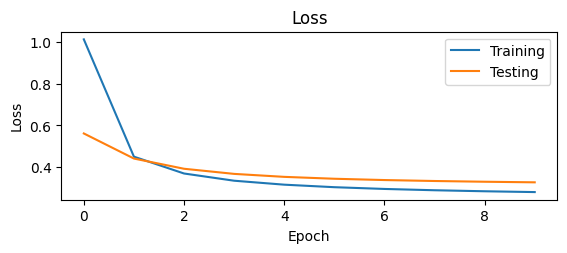

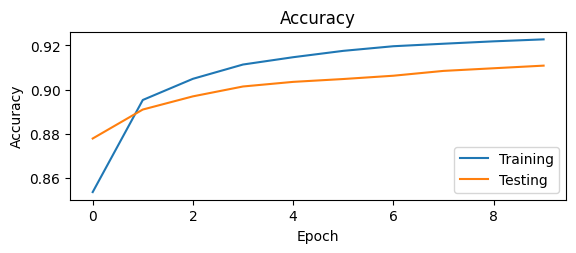

In [7]:
batch_size = 64
learning_rate = 1e-4
epochs = 10
input_dim = 1
hidden_dim_list = [4, 8]
output_dim = 10

model = SimpleCNN(input_dim=input_dim, output_dim=output_dim, hidden_dim_list=hidden_dim_list)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_losses, test_losses, train_accuracies, test_accuracies = train(model, loss_fn, train_loader, test_loader, optimizer, epochs=epochs)

plt.subplot(2, 1, 1)
plot_metrics(train_losses, test_losses, xlabel="Epoch", ylabel="Loss", title="Loss")
plt.subplot(2, 1, 2)
plot_metrics(train_accuracies, test_accuracies, xlabel="Epoch", ylabel="Accuracy", title="Accuracy")

### Step 3: Improve the SimpleCNN

As you can see in the previous step, the training accuracy of the ``SimpleCNN`` is poor. In this step, you will improve the performance of the ``SimpleCNN`` by adding ``nn.MaxPool2d``, ``nn.Dropout``, and activation functions.

**Hint**: The max pooling layer is used to downsample the input along the spatial dimensions (width and height) independently for each channel. It is recommended to add the max pooling layer after the activation function.

In [8]:
class CNN(nn.Module):
    def __init__(
        self,
        input_dim: int = 1,
        output_dim: int = 10,
        hidden_dim_list: list = [4, 8],
        p: float = 0.0,
        act_fn: Callable = F.relu,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim_list = hidden_dim_list

        dim0 = hidden_dim_list[0]
        dim1 = hidden_dim_list[1]
        self.conv_1 = torch.nn.Conv2d(input_dim, dim0, 5, padding=2)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.conv_2 = torch.nn.Conv2d(dim0, dim1, 5, padding=2)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.fc = torch.nn.Linear(dim1 * 7 * 7, output_dim)
        self.act_fn = act_fn
        self.dropout = torch.nn.Dropout2d(p=p)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.dropout(x)
        x = self.act_fn(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.dropout(x)
        x = self.act_fn(x)
        x = self.pool_2(x)
        x = torch.nn.Flatten()(x)
        x = self.fc(x)
        return x

Again, use the training function and the same set of hyperparameters above to train your ``CNN`` on ``MNIST dataset``. You should get a training accuracy around 95%.

Epoch 10: 100%|██████████| 10/10 [02:14<00:00, 13.44s/it, test_accuracy=0.951, test_loss=0.164, train_accuracy=0.949, train_loss=0.17]


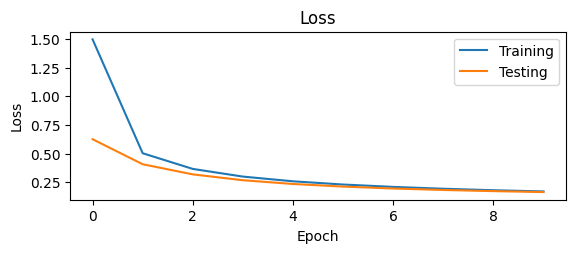

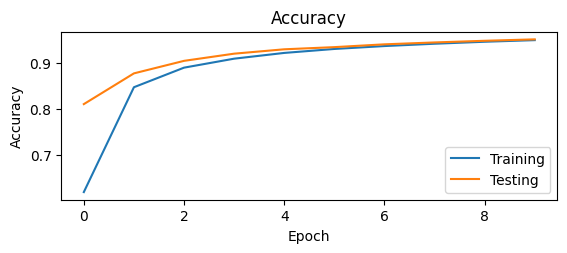

In [9]:
batch_size = 64
learning_rate = 1e-4
epochs = 10
input_dim = 1
hidden_dim_list = [4, 8]
output_dim = 10
act_fn = F.relu
p = 0.0

model = CNN(input_dim=input_dim, output_dim=output_dim, hidden_dim_list=hidden_dim_list, p=p, act_fn=act_fn)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_losses, test_losses, train_accuracies, test_accuracies = train(model, loss_fn, train_loader, test_loader, optimizer, epochs=epochs)

plt.subplot(2, 1, 1)
plot_metrics(train_losses, test_losses, xlabel="Epoch", ylabel="Loss", title="Loss")
plt.subplot(2, 1, 2)
plot_metrics(train_accuracies, test_accuracies, xlabel="Epoch", ylabel="Accuracy", title="Accuracy")

Here are the experiments:
- Try adjusting the learning rate to improve its accuracy. You might also try increasing the number of epochs used. Record your results in a table.
- Try training your network with different non-linearities between the layers (i.e. relu, softplus, elu, tanh). You should experiment with these and record your test results for each in a table
- Try changing the width of the hidden layer, keeping the activation function that performs best. Remember to add these results to your table.
- Experiment with the optimizer of your network (i.e. SGD, Adam, RMSProp). You should experiment with these and record your test results for each in a table

Epoch 10: 100%|██████████| 10/10 [02:35<00:00, 15.57s/it, test_accuracy=0.984, test_loss=0.0472, train_accuracy=0.982, train_loss=0.0561]


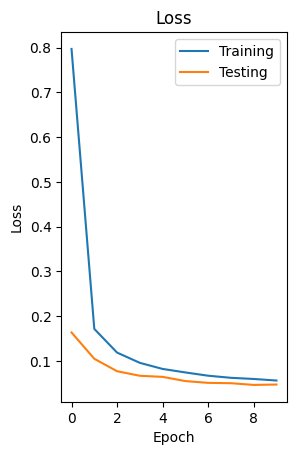

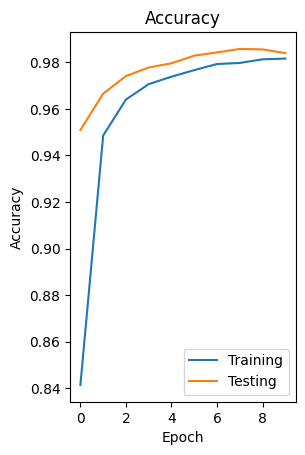

In [10]:
batch_size = 64
learning_rate = 1e-3 * 0.5
epochs = 10
input_dim = 1
hidden_dim_list = [4, 8]
output_dim = 10
act_fn = F.gelu
p = 1e-2 * 5 # 5% dropout probability

model = CNN(input_dim=input_dim, output_dim=output_dim, hidden_dim_list=hidden_dim_list, p=p, act_fn=act_fn)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_losses, test_losses, train_accuracies, test_accuracies = train(model, loss_fn, train_loader, test_loader, optimizer, epochs=epochs)

plt.subplot(1, 2, 1)
plot_metrics(train_losses, test_losses, xlabel="Epoch", ylabel="Loss", title="Loss")
plt.subplot(1, 2, 2)
plot_metrics(train_accuracies, test_accuracies, xlabel="Epoch", ylabel="Accuracy", title="Accuracy")

### Step 4: Hyperparameter Tuning

Now the interesting part begins. Try to improve the performance of your ``CNN`` by tuning the hyperparameters. You should be able to get a training accuracy around 98% and a validation accuracy around 97%.

Here are some new parameters you can try to improve the performance of your model:
- ``Optimizer (SGD, Adam, RMSProp, etc)``: Different optimizers may lead to different convergence speed and performance.
- ``Weight decay (L2 penalty)``: Weight decay is a regularization technique to prevent overfitting. It is recommended to use a small weight decay value (e.g., 1e-4).
- ``Activation function (ReLU, Leaky ReLU, Tanh, etc)``: Different activation functions may lead to different convergence speed and performance.
- ``Dropout rate``: Dropout is a regularization technique to prevent overfitting. It is recommended to use a small dropout rate (e.g., 0.2).
- ...

Please implement a grid search algorithm to find the best set of hyperparameters and report the best validation accuracy you can get. Any hyperparameter can be tuned!

Epoch 10: 100%|██████████| 10/10 [02:19<00:00, 13.99s/it, test_accuracy=0.973, test_loss=0.0828, train_accuracy=0.975, train_loss=0.08]


Final accuracy for model with learning rate 0.0001, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.0, and optimizer <class 'torch.optim.adam.Adam'>: 97.32285031847134%


Epoch 10: 100%|██████████| 10/10 [02:25<00:00, 14.57s/it, test_accuracy=0.975, test_loss=0.082, train_accuracy=0.975, train_loss=0.0795]


Final accuracy for model with learning rate 0.0001, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.01, and optimizer <class 'torch.optim.adam.Adam'>: 97.45222929936305%


Epoch 10: 100%|██████████| 10/10 [02:23<00:00, 14.32s/it, test_accuracy=0.978, test_loss=0.0665, train_accuracy=0.972, train_loss=0.0908]


Final accuracy for model with learning rate 0.0001, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.05, and optimizer <class 'torch.optim.adam.Adam'>: 97.78065286624204%


Epoch 10: 100%|██████████| 10/10 [02:33<00:00, 15.36s/it, test_accuracy=0.976, test_loss=0.0712, train_accuracy=0.977, train_loss=0.0749]


Final accuracy for model with learning rate 0.0001, activation function <built-in function gelu>, dropout probability 0.0, and optimizer <class 'torch.optim.adam.Adam'>: 97.64132165605095%


Epoch 10: 100%|██████████| 10/10 [02:39<00:00, 15.94s/it, test_accuracy=0.977, test_loss=0.0696, train_accuracy=0.979, train_loss=0.0704]


Final accuracy for model with learning rate 0.0001, activation function <built-in function gelu>, dropout probability 0.01, and optimizer <class 'torch.optim.adam.Adam'>: 97.65127388535032%


Epoch 10: 100%|██████████| 10/10 [02:39<00:00, 15.98s/it, test_accuracy=0.976, test_loss=0.072, train_accuracy=0.969, train_loss=0.0987]


Final accuracy for model with learning rate 0.0001, activation function <built-in function gelu>, dropout probability 0.05, and optimizer <class 'torch.optim.adam.Adam'>: 97.62141719745223%


Epoch 10: 100%|██████████| 10/10 [02:19<00:00, 13.91s/it, test_accuracy=0.98, test_loss=0.0631, train_accuracy=0.988, train_loss=0.0363]


Final accuracy for model with learning rate 0.0005, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.0, and optimizer <class 'torch.optim.adam.Adam'>: 97.98964968152866%


Epoch 10: 100%|██████████| 10/10 [02:22<00:00, 14.21s/it, test_accuracy=0.982, test_loss=0.0611, train_accuracy=0.985, train_loss=0.0466]


Final accuracy for model with learning rate 0.0005, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.01, and optimizer <class 'torch.optim.adam.Adam'>: 98.19864649681529%


Epoch 10: 100%|██████████| 10/10 [02:22<00:00, 14.21s/it, test_accuracy=0.98, test_loss=0.0591, train_accuracy=0.98, train_loss=0.0635]


Final accuracy for model with learning rate 0.0005, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.05, and optimizer <class 'torch.optim.adam.Adam'>: 98.04936305732484%


Epoch 10: 100%|██████████| 10/10 [02:31<00:00, 15.13s/it, test_accuracy=0.979, test_loss=0.0811, train_accuracy=0.989, train_loss=0.0378]


Final accuracy for model with learning rate 0.0005, activation function <built-in function gelu>, dropout probability 0.0, and optimizer <class 'torch.optim.adam.Adam'>: 97.88017515923568%


Epoch 10: 100%|██████████| 10/10 [02:36<00:00, 15.64s/it, test_accuracy=0.984, test_loss=0.057, train_accuracy=0.985, train_loss=0.0471]


Final accuracy for model with learning rate 0.0005, activation function <built-in function gelu>, dropout probability 0.01, and optimizer <class 'torch.optim.adam.Adam'>: 98.38773885350318%


Epoch 10: 100%|██████████| 10/10 [02:34<00:00, 15.40s/it, test_accuracy=0.983, test_loss=0.0536, train_accuracy=0.981, train_loss=0.0598]


Final accuracy for model with learning rate 0.0005, activation function <built-in function gelu>, dropout probability 0.05, and optimizer <class 'torch.optim.adam.Adam'>: 98.30812101910828%


Epoch 10: 100%|██████████| 10/10 [02:15<00:00, 13.51s/it, test_accuracy=0.977, test_loss=0.0903, train_accuracy=0.985, train_loss=0.0472]


Final accuracy for model with learning rate 0.001, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.0, and optimizer <class 'torch.optim.adam.Adam'>: 97.74084394904459%


Epoch 10: 100%|██████████| 10/10 [02:20<00:00, 14.00s/it, test_accuracy=0.982, test_loss=0.0606, train_accuracy=0.984, train_loss=0.051]


Final accuracy for model with learning rate 0.001, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.01, and optimizer <class 'torch.optim.adam.Adam'>: 98.22850318471338%


Epoch 10: 100%|██████████| 10/10 [02:17<00:00, 13.75s/it, test_accuracy=0.984, test_loss=0.0592, train_accuracy=0.98, train_loss=0.0649]


Final accuracy for model with learning rate 0.001, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.05, and optimizer <class 'torch.optim.adam.Adam'>: 98.39769108280255%


Epoch 10: 100%|██████████| 10/10 [02:28<00:00, 14.84s/it, test_accuracy=0.98, test_loss=0.0724, train_accuracy=0.985, train_loss=0.0488]


Final accuracy for model with learning rate 0.001, activation function <built-in function gelu>, dropout probability 0.0, and optimizer <class 'torch.optim.adam.Adam'>: 98.00955414012739%


Epoch 10: 100%|██████████| 10/10 [02:31<00:00, 15.18s/it, test_accuracy=0.977, test_loss=0.0843, train_accuracy=0.984, train_loss=0.0507]


Final accuracy for model with learning rate 0.001, activation function <built-in function gelu>, dropout probability 0.01, and optimizer <class 'torch.optim.adam.Adam'>: 97.65127388535032%


Epoch 10: 100%|██████████| 10/10 [02:34<00:00, 15.44s/it, test_accuracy=0.976, test_loss=0.0734, train_accuracy=0.98, train_loss=0.0649]


Final accuracy for model with learning rate 0.001, activation function <built-in function gelu>, dropout probability 0.05, and optimizer <class 'torch.optim.adam.Adam'>: 97.61146496815286%
Best accuracy: 0.9839769108280255
Best model: CNN(
  (conv_1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=392, out_features=10, bias=True)
  (dropout): Dropout2d(p=0.05, inplace=False)
)


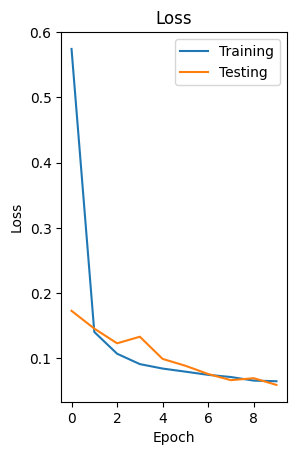

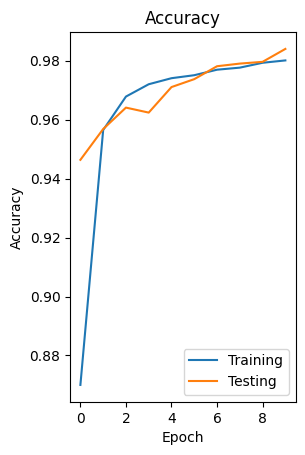

In [11]:
# Grid search
batch_size = 64
learning_rate = [1e-4, 1e-3 * 0.5, 1e-3]
epochs = 10
input_dim = 1
hidden_dim_list = [4, 8]    # to save time, don't tune this
output_dim = 10
act_fn = [F.relu, F.gelu]
dropout = [0.0, 0.01, 0.05]
optimizer_callable = [torch.optim.Adam]

loss_fn = torch.nn.CrossEntropyLoss()

best_accuracy = 0
best_model = None
best_history = None
save_path = '/best_model.pth'
for lr in learning_rate:
    for af in act_fn:
        for p in dropout:
            for oc in optimizer_callable:
                # hyperparams = {'Learning rate': lr, 'Activation function': af, 'Dropout probability': p, 'Optimizer': oc}
                model = CNN(input_dim=input_dim, output_dim=output_dim, hidden_dim_list=hidden_dim_list, p=p, act_fn=af)
                optimizer = oc(model.parameters(), lr=lr, weight_decay=1e-4)
                history = train(model=model, loss_fn=loss_fn, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, epochs=epochs)
                acc = history[3][-1]
                print(f"Final accuracy for model with learning rate {lr}, activation function {af}, dropout probability {p}, and optimizer {oc}: {100 * acc}%")
                if acc > best_accuracy:
                    best_accuracy = acc
                    best_model = model
                    best_history = history
                    # save the best model's weights for good measure
                    torch.save(model.state_dict(), save_path)




print(f"Best accuracy: {best_accuracy}")
print(f"Best model: {best_model}")


plt.subplot(1, 2, 1)
plot_metrics(best_history[0], best_history[1], xlabel="Epoch", ylabel="Loss", title="Loss")
plt.subplot(1, 2, 2)
plot_metrics(best_history[2], best_history[3], xlabel="Epoch", ylabel="Accuracy", title="Accuracy")

### Step 5 Confusion Matrix
With your best performing model, plot a confusion matrix showing which digits were misclassified, and what they were misclassified as. What numbers are frequently confused with one another by your model?

In [20]:
from sklearn.metrics import confusion_matrix

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

dataiter = iter(test_loader)
data, target = next(dataiter)

model = CNN(input_dim=input_dim,
            output_dim=output_dim,
            hidden_dim_list=hidden_dim_list,
            p=0.05,
            act_fn=F.relu)
model.load_state_dict(torch.load(save_path))
model.eval()  # set model to evaluation mode

outputs = model(data)
_, predicted = torch.max(outputs, 1)

conf = confusion_matrix(target, predicted)

print("Confusion matrix for best performing model:")
print(conf)



<ipython-input-20-45dc9018cc49>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Confusion matrix for best performing model:
[[ 966    2    1    0    1    2    3    1    4    0]
 [   1 1130    0    1    1    0    1    0    1    0]
 [   1    4 1018    4    1    0    1    3    0    0]
 [   0    0    1  993    0   12    0    0    3    1]
 [   0    0    1    0  974    0    0    0    2    5]
 [   1    0    0    2    0  888    1    0    0    0]
 [   2    3    0    1    1   11  933    0    7    0]
 [   0    4   13    2    1    2    0 1001    2    3]
 [   1    0    2    1    0    4    0    0  964    2]
 [   1    3    0    1   11    6    0   12    3  972]]
